In [1]:
import os
import time
import pickle
import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df, mase_loss, mean_absolute_scaled_error, compute_mase_scale, get_torch_criterion, get_confidence_interval, winkler_score
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Ablation Study on Temporal Features
Precovid Sanity Test (Experiment 1)

In [3]:
country_list = ['Canada', 'Chile', 'Mexico', 'Chinese Taipei', 'Hong Kong SAR', 'Japan', 
                'Korea (ROK)', 'Macao, China', 'Maldives', 'Cambodia', 'Indonesia', 'Singapore', 
                'New Zealand', 'USA', 'Thailand', 'Turkey', 'Australia', 'Hawaii', 'Austria', 'Czech']

imputed_dir = './data/imputed/'

# Preprocessing Data

In [4]:
target = 'VisitorArrivals'
candidates = ['FXAgainstChina', 'CovidCases', 'CovidDeaths', 'FSI',
               'GDPPerCap', 'GDP', 'Population',
               'TravelPolicy', 'Temperature', 'Precipitation', 'GlobalCovidTrend',
               'DistFromChina', 'Country', 'GDPRatioChina',
               'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
               'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
               'ChinaGDP']
def load_data(country='Japan', csv_dir='./data/imputed', log_transform=True, dropna=True, remove_covid=False):
    df = pd.read_csv(os.path.join(csv_dir, f'{country}.csv'))
    if dropna:
        df = df.iloc[df['VisitorArrivals'].first_valid_index():].reset_index(drop=True)
    if log_transform:
        df['VisitorArrivals'] = np.log1p(df['VisitorArrivals'])
    df['Date'] = pd.to_datetime(df['Date'])
    if remove_covid:
        # df = df[df['Date'] < ('2019-07-01' if country in ['Hong Kong SAR', 'Chinese Taipei'] else '2020-01-01')]
        df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date').asfreq('MS')
    return df[candidates + [target]]

In [5]:
df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1997-01-01 to 2024-07-01
Freq: MS
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FXAgainstChina            331 non-null    float64
 1   CovidCases                319 non-null    float64
 2   CovidDeaths               319 non-null    float64
 3   FSI                       331 non-null    float64
 4   GDPPerCap                 331 non-null    float64
 5   GDP                       331 non-null    float64
 6   Population                331 non-null    float64
 7   TravelPolicy              331 non-null    float64
 8   Temperature               331 non-null    float64
 9   Precipitation             331 non-null    float64
 10  GlobalCovidTrend          331 non-null    float64
 11  DistFromChina             331 non-null    float64
 12  Country                   331 non-null    object 
 13  GDPRatioChina             331 non-nul

In [6]:
from src.utils import get_seasonal_component, inverse_target
#load all data and decomposed precovid seasonality
def load_and_preprocess_all(test_size=0, deduct_seasonality=True, single_x_scaler=False, single_y_scaler=False, scaler_type='standard', remove_covid=False):
    all_data = {country: load_data(country, remove_covid=remove_covid) for country in country_list}
    all_decomposed_seasonal = {country: seasonal_decompose(df[df.index < '2020-01-01']['VisitorArrivals'], period=12) for country, df in all_data.items()}
    
    x_scaler, y_scaler = {}, {}
    #some feature engineering and processing
    for country in country_list:
        all_data[country]['Popularity'] = all_data[country]['VisitorArrivals'].median()
        all_data[country]['Unrest'] = 0.
        all_data[country]['TravelRestriction'] = (all_data[country][['TravelPolicy', 'ChinaConfinementPolicy', 'ChinaMovementPolicy']] > 0).all(axis=1).astype(int)
        
        all_data[country]['Year'] = all_data[country].index.year
        all_data[country]['MonthSin'] = np.sin(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        all_data[country]['MonthCos'] = np.cos(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        
        all_data[country]['Month'] = all_data[country].index.month.astype(int)
        dummy_month = pd.get_dummies(all_data[country]['Month'].astype(str), prefix='Month', dtype=float)
        all_data[country][dummy_month.columns] = dummy_month
        
        if deduct_seasonality:
            # remove seasonality
            seasonal_component = get_seasonal_component(all_decomposed_seasonal[country], len(all_data[country]))
            assert len(seasonal_component) == len(all_data[country])
            seasonal_component.index = all_data[country].index
            all_data[country]['VisitorArrivals'] -= seasonal_component
            
        # 1. taiwan ban china starting september 2019 - january 2024 election
        # 2. hong kong protest starting august 2019 end mid 2020
        # 3. china ban korea starting march 2017 - nov 2017
        # 4. singapore and thailand april 2014 - jan 2015
        # 5. sars world april 2003 - july 2003
        # 6. hawaii and USA trump presidential between november 2016 to january 2021
        # 7. turkey coup 2016
        if country == 'Chinese Taipei':
            all_data[country].loc[(all_data[country].index >= '2019-09-01') & (all_data[country].index <= '2024-02-01'), 'TravelRestriction'] = 1
        elif country == 'Hong Kong SAR':
            all_data[country].loc[(all_data[country].index >= '2019-08-01') & (all_data[country].index <= '2020-06-01'), 'Unrest'] = 1.
        elif country == 'Korea (ROK)':
            all_data[country].loc[(all_data[country].index >= '2017-03-01') & (all_data[country].index <= '2017-11-01'), 'TravelRestriction'] = 1
        elif country in ['Singapore', 'Thailand']:
            all_data[country].loc[(all_data[country].index >= '2014-04-01') & (all_data[country].index <= '2015-01-01'), 'Unrest'] = 1.
        elif country in ['Hawaii', 'USA']:
            all_data[country].loc[(all_data[country].index >= '2016-11-01') & (all_data[country].index <= '2021-01-01'), 'Unrest'] = 0.5
        elif country == 'Turkey':
            all_data[country].loc[(all_data[country].index >= '2015-12-01') & (all_data[country].index <= '2017-02-01'), 'Unrest'] = 1.
            
        all_data[country].loc[(all_data[country].index >= '2003-04-01') & (all_data[country].index <= '2003-07-01'), 'Unrest'] = 1. # SARS

        # assume covid case and deaths exponentially reduce
        for c in ['CovidCases', 'CovidDeaths']:
            all_data[country][c] = all_data[country][c].fillna(all_data[country][c].ffill()[all_data[country][c].isnull()].mul((1/2)**(all_data[country][c].groupby(all_data[country][c].notnull().cumsum()).cumcount()), 0)).round()
    
    country_feat = ['GDPPerCap', 'GDP', 'Population', 'CovidCases', 'CovidDeaths', 
                    'Temperature', 'Precipitation',]  # only normalize country specific features, other features are universal which will be normalize separately
    if single_x_scaler:
        temp_df = pd.concat([all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)  # only fit on train that is valid
        x_scaler = get_scaler(scaler_type)
        x_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][country_feat] = x_scaler.transform(all_data[country][country_feat])
    else:
        for country in country_list:
            country_x_scaler = get_scaler(scaler_type)
            country_x_scaler.fit(all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][country_feat] = country_x_scaler.transform(all_data[country][country_feat])
            x_scaler[country] = country_x_scaler
    
    universal_feat = ['FXAgainstChina', 'FSI', 'Year', 'MonthSin', 'MonthCos', 'Unrest',
                       'TravelPolicy', 'GlobalCovidTrend',
                       'DistFromChina', 'GDPRatioChina',
                       'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                       'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                       'ChinaGDP', 'Popularity', 'TravelRestriction']
    universal_x_scaler = get_scaler(scaler_type)
    temp_df = pd.concat([all_data[country][universal_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)
    universal_x_scaler.fit(temp_df)
    for country in country_list:
        all_data[country][universal_feat] = universal_x_scaler.transform(all_data[country][universal_feat])
        
    if single_y_scaler:
        temp_df = pd.concat([all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True) # only fit on train
        y_scaler = get_scaler(scaler_type)
        y_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][[target]] = y_scaler.transform(all_data[country][[target]])
    else:
        for country in country_list:
            country_y_scaler = get_scaler(scaler_type)
            country_y_scaler.fit(all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][[target]] = country_y_scaler.transform(all_data[country][[target]])
            y_scaler[country] = country_y_scaler
    
    return all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler

In [7]:
deduct_seasonality = True
single_x_scaler = False
single_y_scaler = False
all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler = load_and_preprocess_all(test_size=12, deduct_seasonality=deduct_seasonality, single_x_scaler=single_x_scaler, single_y_scaler=single_y_scaler, remove_covid=True)

<Axes: xlabel='Date'>

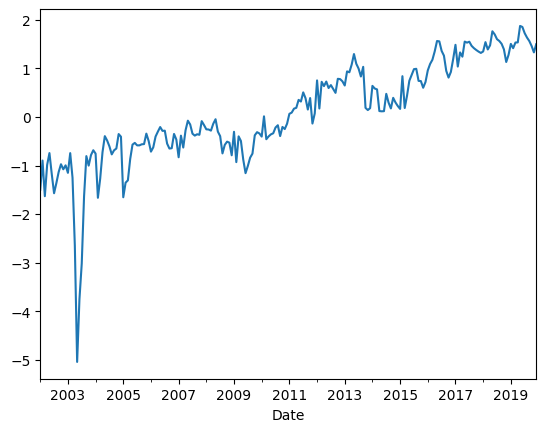

In [8]:
country = 'Singapore'
all_data[country]['VisitorArrivals'].plot()

In [9]:
all_data[country]

,FXAgainstChina,CovidCases,CovidDeaths,FSI,GDPPerCap,GDP,Population,TravelPolicy,Temperature,Precipitation,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,-0.258922,0.0,0.0,-0.701804,-1.933853,-1.681899,-1.598512,0.0,-0.877961,-0.362024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-02-01,-0.258925,0.0,0.0,-0.701804,-1.910476,-1.669684,-1.594969,0.0,-0.050308,-1.490460,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-03-01,-0.258927,0.0,0.0,-0.701804,-1.887099,-1.657470,-1.591424,0.0,1.108406,-0.913265,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-04-01,-0.258927,0.0,0.0,-0.701804,-1.863722,-1.645255,-1.587880,0.0,1.439467,-0.329842,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2002-05-01,-0.258939,0.0,0.0,-0.701804,-1.840345,-1.633041,-1.584336,0.0,1.936058,-0.115989,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,-0.259016,0.0,0.0,-1.024345,1.426329,1.490276,1.360326,0.0,0.942875,-1.415715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-09-01,-0.259024,0.0,0.0,-1.024345,1.400218,1.476286,1.366896,0.0,0.611814,-1.567281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-10-01,-0.259026,0.0,0.0,-1.024345,1.374108,1.462296,1.373464,0.0,-0.050308,-0.212535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
all_data[country].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2002-01-01 to 2019-12-01
Freq: MS
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FXAgainstChina            216 non-null    float64
 1   CovidCases                216 non-null    float64
 2   CovidDeaths               216 non-null    float64
 3   FSI                       216 non-null    float64
 4   GDPPerCap                 216 non-null    float64
 5   GDP                       216 non-null    float64
 6   Population                216 non-null    float64
 7   TravelPolicy              216 non-null    float64
 8   Temperature               216 non-null    float64
 9   Precipitation             216 non-null    float64
 10  GlobalCovidTrend          216 non-null    float64
 11  DistFromChina             216 non-null    float64
 12  Country                   216 non-null    object 
 13  GDPRatioChina             216 non-nul

# No Temporal Features
### RNN

In [15]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', #'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1,):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2

    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x[:-test_size*output_len], y[:-test_size*output_len], mase[:-test_size*output_len], x[-test_size:], y[-test_size:], mase[-test_size:]

In [16]:
# repeat for all countries
all_train_x, all_train_y, all_test_x, all_test_y = [], [], [], []
for country, df in all_data.items():
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    
    all_train_x.append(train_x)
    all_train_y.append(train_y)
    all_test_x.append(test_x)
    all_test_y.append(test_y)

all_train_x = pd.concat(all_train_x, ignore_index=True)
all_train_y = pd.concat(all_train_y, ignore_index=True)

In [17]:
y_mase_scales = []
for c in country_list:
    f = c + '.csv'
    df = pd.read_csv(os.path.join(imputed_dir, f))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date')
    train_y = df[target]
    train_y = train_y.loc[train_y.first_valid_index(): train_y.last_valid_index()]
    for i in range(12, 0, -1):
        y_mase_scales.append(compute_mase_scale(train_y.iloc[:-i].values))

y_mase_scales = np.asarray(y_mase_scales)

In [18]:
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, _, seq_test_x, seq_test_y, _ = sliding_window(all_data[country], input_len=60, 
                                                                      output_len=12, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

Epoch 0: train loss 1.8848, val loss 1.4372, time 1.3655
Epoch 1: train loss 0.9252, val loss 0.9071, time 1.1844
Epoch 2: train loss 0.8177, val loss 0.8606, time 1.1863
Epoch 3: train loss 0.7891, val loss 0.8453, time 1.1915
Epoch 4: train loss 0.7810, val loss 0.8266, time 1.1792
Epoch 5: train loss 0.7426, val loss 0.8247, time 1.1866
Epoch 6: train loss 0.7376, val loss 0.8301, time 1.1837
Epoch 7: train loss 0.7299, val loss 0.8056, time 1.1855
Epoch 8: train loss 0.7180, val loss 0.8123, time 1.1987
Epoch 9: train loss 0.7076, val loss 0.7953, time 1.1900
Epoch 10: train loss 0.7119, val loss 1.0226, time 1.1910
Epoch 11: train loss 0.7056, val loss 0.8368, time 1.1850
Epoch 12: train loss 0.7028, val loss 0.9016, time 1.1907
Epoch 13: train loss 0.7000, val loss 0.9268, time 1.1920
Early stopping as no improvement in val loss


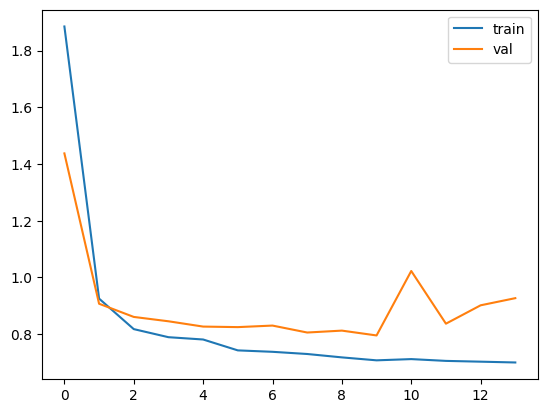

In [29]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})

output_size=12
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                          output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)
test_mase_ori = np.concatenate(test_mase_ori)

model = ForecastModel(**best_param[1], input_size=16, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [30]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

In [31]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y, _ = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [32]:
all_y = rnn_gt

In [33]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}'
      f'\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 403946.50616
RNN R2: 0.81158
RNN MAE: 114888.26272
RNN MAPE: 0.25794
RNN MASE: 2.55218


## One Step RNN

In [55]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', #'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

Epoch 0: train loss 1.2826, val loss 0.6719, time 1.5824
Epoch 1: train loss 0.7934, val loss 0.7316, time 1.3990
Epoch 2: train loss 0.6037, val loss 0.7825, time 1.4005
Epoch 3: train loss 0.5767, val loss 0.5056, time 1.3949
Epoch 4: train loss 0.5434, val loss 0.5176, time 1.3986
Epoch 5: train loss 0.5432, val loss 0.6394, time 1.3971
Epoch 6: train loss 0.5356, val loss 0.4782, time 1.4248
Epoch 7: train loss 0.5438, val loss 0.5988, time 1.3894
Epoch 8: train loss 0.5494, val loss 0.5115, time 1.3942
Epoch 9: train loss 0.5392, val loss 0.6538, time 1.4039
Epoch 10: train loss 0.5214, val loss 0.5783, time 1.3941
Epoch 11: train loss 0.5204, val loss 0.6082, time 1.3894
Epoch 12: train loss 0.5253, val loss 0.4807, time 1.3900
Epoch 13: train loss 0.5039, val loss 0.5249, time 1.3980
Early stopping as no improvement in val loss


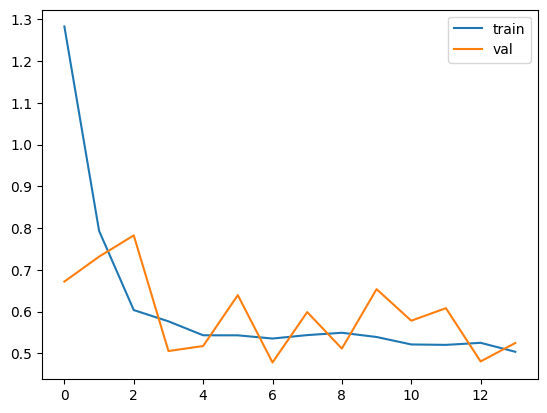

In [56]:
best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.001})
output_size=1
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori).squeeze()
test_mase_ori = np.concatenate(test_mase_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=16, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [57]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

In [58]:
rnn_os_pred, rnn_gt = [], []

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    rnn_os_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
    
rnn_gt = np.concatenate(rnn_gt)
rnn_os_pred = np.concatenate(rnn_os_pred)

In [59]:
(rnn_gt == all_y).all()

True

In [60]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_os_pred))
rnn_r2 = r2_score(all_y, rnn_os_pred)
rnn_mae = mean_absolute_error(all_y, rnn_os_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_os_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_os_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 313510.20339
RNN R2: 0.88650
RNN MAE: 85903.52071
RNN MAPE: 0.21186
RNN MASE: 2.17813


### Separate RNN models

In [63]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest',# 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
# static_feat = ['DistFromChina', 'Popularity']

In [ ]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=15, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = get_torch_criterion('mase')

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y, mases=train_mase)# (model.num_layers, model.hidden_size))
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y, mases=test_mase)# (model.num_layers, model.hidden_size))
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, early_stop_patience=10, cuda=True, epochs=100, mase=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

    _, ds_x, ds_y, _ = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))

rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

In [65]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
rnn_sep_mase = mean_absolute_scaled_error(all_y, rnn_sep_pred, y_mase_scales)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}'
      f'\nRNN Sep MAPE: {rnn_sep_mape:.5f}\nRNN Sep MASE: {rnn_sep_mase:.5f}')

RNN Sep RMSE: 301901.57767
RNN Sep R2: 0.89475
RNN Sep MAE: 98764.29282
RNN Sep MAPE: 0.18198
RNN Sep MASE: 2.06255


### Ensemble RNN models

In [66]:
for w in range(10):
    w = w / 10
    ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
    ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    print(f'Weight: {w}, RMSE: {ens_rmse:.5f}')
w = 0.5
ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred

Weight: 0.0, RMSE: 313510.20339
Weight: 0.1, RMSE: 307005.96506
Weight: 0.2, RMSE: 301587.14439
Weight: 0.3, RMSE: 297313.09567
Weight: 0.4, RMSE: 294233.71012
Weight: 0.5, RMSE: 292386.73638
Weight: 0.6, RMSE: 291795.57770
Weight: 0.7, RMSE: 292467.84925
Weight: 0.8, RMSE: 294394.89575
Weight: 0.9, RMSE: 297552.33920


In [67]:
rnn_ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
rnn_ens_r2 = r2_score(all_y, ensemble_pred)
rnn_ens_mae = mean_absolute_error(all_y, ensemble_pred)
rnn_ens_mape = mean_absolute_percentage_error(all_y, ensemble_pred)
rnn_ens_mase = mean_absolute_scaled_error(all_y, ensemble_pred, y_mase_scales)

print(f'RNN Ensemble RMSE: {rnn_ens_rmse:.5f}\nRNN Ensemble R2: {rnn_ens_r2:.5f}\nRNN Ensemble MAE: {rnn_ens_mae:.5f}'
      f'\nRNN Ensemble MAPE: {rnn_ens_mape:.5f}\nRNN Ensemble MASE: {rnn_ens_mase:.5f}')

RNN Ensemble RMSE: 292386.73638
RNN Ensemble R2: 0.90128
RNN Ensemble MAE: 84835.45187
RNN Ensemble MAPE: 0.18473
RNN Ensemble MASE: 1.97643


# Ordinal Temporal Features
### RNN

In [46]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Month', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1,):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2

    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x[:-test_size*output_len], y[:-test_size*output_len], mase[:-test_size*output_len], x[-test_size:], y[-test_size:], mase[-test_size:]

In [47]:
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, _, seq_test_x, seq_test_y, _ = sliding_window(all_data[country], input_len=60, 
                                                                      output_len=12, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

Epoch 0: train loss 1.8987, val loss 1.3605, time 1.6327
Epoch 1: train loss 1.0186, val loss 0.9823, time 1.4341
Epoch 2: train loss 0.8531, val loss 0.9267, time 1.4402
Epoch 3: train loss 0.8142, val loss 0.8877, time 1.4451
Epoch 4: train loss 0.7896, val loss 0.8822, time 1.4552
Epoch 5: train loss 0.7620, val loss 0.8707, time 1.4628
Epoch 6: train loss 0.7571, val loss 0.8609, time 1.4479
Epoch 7: train loss 0.7478, val loss 0.9202, time 1.3989
Epoch 8: train loss 0.7428, val loss 0.8429, time 1.4089
Epoch 9: train loss 0.7218, val loss 0.8359, time 1.3989
Epoch 10: train loss 0.7195, val loss 0.8425, time 1.4012
Epoch 11: train loss 0.7202, val loss 0.8289, time 1.4000
Epoch 12: train loss 0.7217, val loss 0.8158, time 1.4058
Epoch 13: train loss 0.7022, val loss 0.8042, time 1.4013
Epoch 14: train loss 0.7017, val loss 1.0863, time 1.4013
Epoch 15: train loss 0.7059, val loss 0.8137, time 1.4263
Epoch 16: train loss 0.7023, val loss 0.8030, time 1.4241
Epoch 17: train loss 0.6

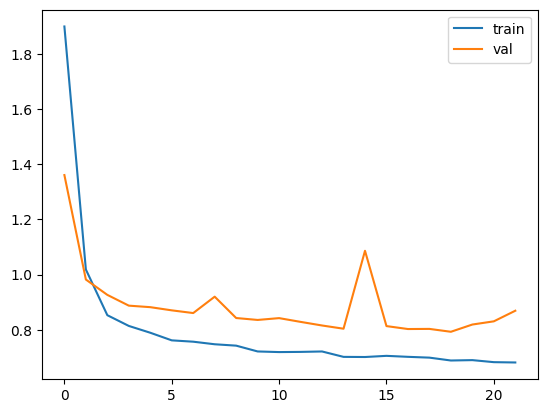

In [48]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})

output_size=12
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                          output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)
test_mase_ori = np.concatenate(test_mase_ori)

model = ForecastModel(**best_param[1], input_size=18, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [49]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

In [50]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y, _ = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [51]:
(all_y == rnn_gt).all()

True

In [52]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}'
      f'\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 427867.85023
RNN R2: 0.78860
RNN MAE: 115182.09997
RNN MAPE: 0.25727
RNN MASE: 2.53401


## One Step RNN

In [65]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest','Month', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

Epoch 0: train loss 1.3829, val loss 0.8542, time 1.8861
Epoch 1: train loss 0.8625, val loss 0.8618, time 1.6511
Epoch 2: train loss 0.7266, val loss 0.6652, time 1.6506
Epoch 3: train loss 0.5770, val loss 0.5224, time 1.6343
Epoch 4: train loss 0.5450, val loss 0.5279, time 1.6324
Epoch 5: train loss 0.5377, val loss 0.5193, time 1.6293
Epoch 6: train loss 0.5220, val loss 0.4980, time 1.6253
Epoch 7: train loss 0.5164, val loss 0.4848, time 1.6346
Epoch 8: train loss 0.5069, val loss 0.5379, time 1.6293
Epoch 9: train loss 0.5355, val loss 0.5389, time 1.6364
Epoch 10: train loss 0.5214, val loss 0.4808, time 1.6320
Epoch 11: train loss 0.5113, val loss 0.4866, time 1.6270
Epoch 12: train loss 0.5212, val loss 0.7970, time 1.6256
Epoch 13: train loss 0.5411, val loss 0.5030, time 1.6918
Early stopping as no improvement in val loss


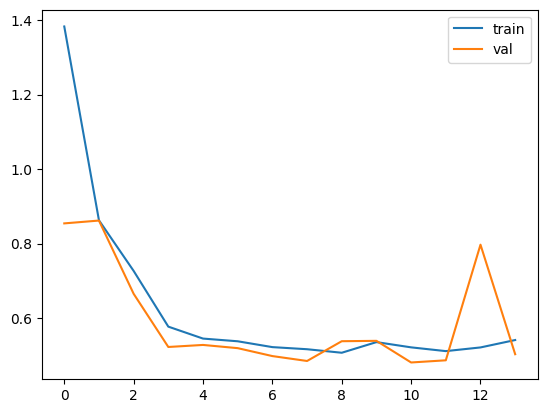

In [66]:
best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.001})
output_size=1
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori).squeeze()
test_mase_ori = np.concatenate(test_mase_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=18, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [67]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

In [68]:
rnn_os_pred, rnn_gt = [], []

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    rnn_os_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
    
rnn_gt = np.concatenate(rnn_gt)
rnn_os_pred = np.concatenate(rnn_os_pred)

In [69]:
(rnn_gt == all_y).all()

True

In [70]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_os_pred))
rnn_r2 = r2_score(all_y, rnn_os_pred)
rnn_mae = mean_absolute_error(all_y, rnn_os_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_os_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_os_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 302474.55317
RNN R2: 0.89435
RNN MAE: 90026.57540
RNN MAPE: 0.21364
RNN MASE: 2.16298


### Separate RNN models

In [74]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Month', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
# static_feat = ['DistFromChina', 'Popularity']

In [ ]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=17, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = get_torch_criterion('mase')

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y, mases=train_mase)# (model.num_layers, model.hidden_size))
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y, mases=test_mase)# (model.num_layers, model.hidden_size))
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, early_stop_patience=10, cuda=True, epochs=100, mase=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

    _, ds_x, ds_y, _ = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))

rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

In [76]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
rnn_sep_mase = mean_absolute_scaled_error(all_y, rnn_sep_pred, y_mase_scales)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}'
      f'\nRNN Sep MAPE: {rnn_sep_mape:.5f}\nRNN Sep MASE: {rnn_sep_mase:.5f}')

RNN Sep RMSE: 323575.33247
RNN Sep R2: 0.87910
RNN Sep MAE: 107790.53889
RNN Sep MAPE: 0.21790
RNN Sep MASE: 2.41849


### Ensemble RNN models

In [78]:
for w in range(10):
    w = w / 10
    ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
    ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    print(f'Weight: {w}, RMSE: {ens_rmse:.5f}')
w = 0.4
ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred

Weight: 0.0, RMSE: 302474.55317
Weight: 0.1, RMSE: 296272.11309
Weight: 0.2, RMSE: 291860.06555
Weight: 0.3, RMSE: 289320.33099
Weight: 0.4, RMSE: 288702.32625
Weight: 0.5, RMSE: 290018.33672
Weight: 0.6, RMSE: 293242.32518
Weight: 0.7, RMSE: 298312.43707
Weight: 0.8, RMSE: 305136.66142
Weight: 0.9, RMSE: 313600.50601


In [79]:
rnn_ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
rnn_ens_r2 = r2_score(all_y, ensemble_pred)
rnn_ens_mae = mean_absolute_error(all_y, ensemble_pred)
rnn_ens_mape = mean_absolute_percentage_error(all_y, ensemble_pred)
rnn_ens_mase = mean_absolute_scaled_error(all_y, ensemble_pred, y_mase_scales)

print(f'RNN Ensemble RMSE: {rnn_ens_rmse:.5f}\nRNN Ensemble R2: {rnn_ens_r2:.5f}\nRNN Ensemble MAE: {rnn_ens_mae:.5f}'
      f'\nRNN Ensemble MAPE: {rnn_ens_mape:.5f}\nRNN Ensemble MASE: {rnn_ens_mase:.5f}')

RNN Ensemble RMSE: 288702.32625
RNN Ensemble R2: 0.90375
RNN Ensemble MAE: 94801.41409
RNN Ensemble MAPE: 0.20519
RNN Ensemble MASE: 2.17164


# One Hot Temporal Features
### RNN

In [80]:
all_data[country].columns

Index(['FXAgainstChina', 'CovidCases', 'CovidDeaths', 'FSI', 'GDPPerCap',
       'GDP', 'Population', 'TravelPolicy', 'Temperature', 'Precipitation',
       'GlobalCovidTrend', 'DistFromChina', 'Country', 'GDPRatioChina',
       'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
       'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
       'ChinaGDP', 'VisitorArrivals', 'Popularity', 'Unrest',
       'TravelRestriction', 'Year', 'MonthSin', 'MonthCos', 'Month', 'Month_1',
       'Month_10', 'Month_11', 'Month_12', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9'],
      dtype='object')

In [81]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction'] + ['Month_'+str(i) for i in range(1, 13)]
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1,):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2

    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x[:-test_size*output_len], y[:-test_size*output_len], mase[:-test_size*output_len], x[-test_size:], y[-test_size:], mase[-test_size:]

In [82]:
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, _, seq_test_x, seq_test_y, _ = sliding_window(all_data[country], input_len=60, 
                                                                      output_len=12, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

In [83]:
len(country_feat + universal_feat)

29

Epoch 0: train loss 1.9179, val loss 1.2755, time 1.3673
Epoch 1: train loss 0.9482, val loss 1.0881, time 1.1825
Epoch 2: train loss 0.8237, val loss 0.8979, time 1.1874
Epoch 3: train loss 0.7857, val loss 0.9074, time 1.1860
Epoch 4: train loss 0.7717, val loss 0.8709, time 1.1797
Epoch 5: train loss 0.7455, val loss 0.8555, time 1.1863
Epoch 6: train loss 0.7419, val loss 0.8546, time 1.1947
Epoch 7: train loss 0.7400, val loss 0.9115, time 1.1956
Epoch 8: train loss 0.7232, val loss 0.8265, time 1.1870
Epoch 9: train loss 0.7271, val loss 0.8851, time 1.1799
Epoch 10: train loss 0.7226, val loss 0.8331, time 1.1813
Epoch 11: train loss 0.7058, val loss 0.8970, time 1.2729
Epoch 12: train loss 0.7048, val loss 0.9139, time 1.1653
Epoch 13: train loss 0.7114, val loss 0.8404, time 1.1807
Early stopping as no improvement in val loss


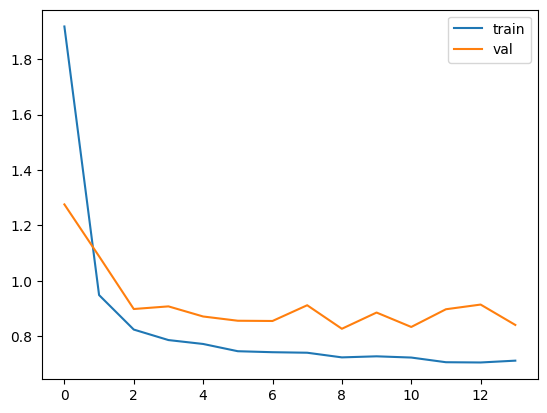

In [85]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})

output_size=12
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                          output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)
test_mase_ori = np.concatenate(test_mase_ori)

model = ForecastModel(**best_param[1], input_size=29, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [86]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

In [87]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y, _ = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [88]:
(all_y == rnn_gt).all()

True

In [89]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}'
      f'\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 415218.54368
RNN R2: 0.80092
RNN MAE: 117720.47590
RNN MAPE: 0.27256
RNN MASE: 2.69457


## One Step RNN

In [111]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction'] + ['Month_'+str(i) for i in range(1, 13)]
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

Epoch 0: train loss 2.0481, val loss 1.1770, time 1.6394
Epoch 1: train loss 1.0943, val loss 0.9512, time 1.4430
Epoch 2: train loss 0.7421, val loss 0.6625, time 1.4681
Epoch 3: train loss 0.6248, val loss 0.7232, time 1.4403
Epoch 4: train loss 0.6022, val loss 0.6259, time 1.4390
Epoch 5: train loss 0.5590, val loss 0.5423, time 1.4358
Epoch 6: train loss 0.5423, val loss 0.7846, time 1.4527
Epoch 7: train loss 0.5414, val loss 0.5274, time 1.4399
Epoch 8: train loss 0.5262, val loss 0.7161, time 1.4273
Epoch 9: train loss 0.5451, val loss 0.5827, time 1.4323
Epoch 10: train loss 0.5283, val loss 0.4964, time 1.4286
Epoch 11: train loss 0.4982, val loss 0.4780, time 1.4288
Epoch 12: train loss 0.5035, val loss 0.7023, time 1.4409
Epoch 13: train loss 0.5197, val loss 0.6440, time 1.4418
Epoch 14: train loss 0.5117, val loss 0.5206, time 1.4381
Early stopping as no improvement in val loss


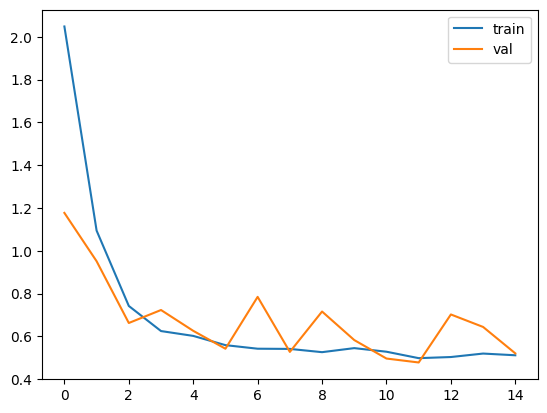

In [112]:
best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.001})
output_size=1
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori).squeeze()
test_mase_ori = np.concatenate(test_mase_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=29, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=50, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [113]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

In [114]:
rnn_os_pred, rnn_gt = [], []

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    rnn_os_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
    
rnn_gt = np.concatenate(rnn_gt)
rnn_os_pred = np.concatenate(rnn_os_pred)

In [115]:
(rnn_gt == all_y).all()

True

In [116]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_os_pred))
rnn_r2 = r2_score(all_y, rnn_os_pred)
rnn_mae = mean_absolute_error(all_y, rnn_os_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_os_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_os_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 303705.80815
RNN R2: 0.89349
RNN MAE: 93441.65073
RNN MAPE: 0.18646
RNN MASE: 2.20677


### Separate RNN models

In [124]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction'] + ['Month_'+str(i) for i in range(1, 13)]
# static_feat = ['DistFromChina', 'Popularity']

In [ ]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=28, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = get_torch_criterion('mase')

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y, mases=train_mase)# (model.num_layers, model.hidden_size))
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y, mases=test_mase)# (model.num_layers, model.hidden_size))
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, early_stop_patience=10, cuda=True, epochs=100, mase=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

    _, ds_x, ds_y, _ = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))

rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)

In [143]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
rnn_sep_mase = mean_absolute_scaled_error(all_y, rnn_sep_pred, y_mase_scales)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}'
      f'\nRNN Sep MAPE: {rnn_sep_mape:.5f}\nRNN Sep MASE: {rnn_sep_mase:.5f}')

RNN Sep RMSE: 276752.47531
RNN Sep R2: 0.91156
RNN Sep MAE: 93658.52959
RNN Sep MAPE: 0.18397
RNN Sep MASE: 2.05913


### Ensemble RNN models

In [144]:
for w in range(10):
    w = w / 10
    ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
    ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    print(f'Weight: {w}, RMSE: {ens_rmse:.5f}')
w = 0.5
ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred

Weight: 0.0, RMSE: 303705.80815
Weight: 0.1, RMSE: 292062.87166
Weight: 0.2, RMSE: 282060.26811
Weight: 0.3, RMSE: 273877.78194
Weight: 0.4, RMSE: 267682.37668
Weight: 0.5, RMSE: 263614.18945
Weight: 0.6, RMSE: 261772.41589
Weight: 0.7, RMSE: 262203.97654
Weight: 0.8, RMSE: 264897.76076
Weight: 0.9, RMSE: 269786.01288


In [145]:
rnn_ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
rnn_ens_r2 = r2_score(all_y, ensemble_pred)
rnn_ens_mae = mean_absolute_error(all_y, ensemble_pred)
rnn_ens_mape = mean_absolute_percentage_error(all_y, ensemble_pred)
rnn_ens_mase = mean_absolute_scaled_error(all_y, ensemble_pred, y_mase_scales)

print(f'RNN Ensemble RMSE: {rnn_ens_rmse:.5f}\nRNN Ensemble R2: {rnn_ens_r2:.5f}\nRNN Ensemble MAE: {rnn_ens_mae:.5f}'
      f'\nRNN Ensemble MAPE: {rnn_ens_mape:.5f}\nRNN Ensemble MASE: {rnn_ens_mase:.5f}')

RNN Ensemble RMSE: 263614.18945
RNN Ensemble R2: 0.91975
RNN Ensemble MAE: 87591.95217
RNN Ensemble MAPE: 0.17614
RNN Ensemble MASE: 2.03554
